# Importing Packages

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error as mse

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge


# Loading prepared Data

In [4]:
data = pd.read_csv('NYC_compiled_data (ACS 5 years).csv')
data.head()

,Zip Code,Latitude,Longitude,POSITIVES,PERCENT_POSI,DEGREES,ENROLLS,ELDER,WHITES,BLACKS,ASIANS,MINORITIES,MED_INCOMES,MEAN_INCOMES,POVERTY,UNEMPLOYMENT
0,10001,40.729825,-73.960752,318,29.17,68.0,63.5,18.5,62.9,6.2,25.2,31.4,88526.0,151628.0,13.3,4.5
1,10002,40.722313,-73.987709,924,38.48,34.0,36.8,24.9,32.2,8.4,41.5,49.9,35859.0,68315.0,27.7,7.0
2,10003,40.731603,-73.988488,413,27.46,80.2,84.2,15.1,75.9,5.8,13.5,19.3,112131.0,189885.0,8.5,5.7
3,10004,40.700741,-74.013467,28,27.72,90.4,25.1,12.4,62.8,1.7,30.4,32.1,157645.0,218650.0,2.2,4.5
4,10005,40.705636,-74.008900,54,21.60,88.4,52.2,1.3,73.4,2.5,17.0,19.5,173333.0,208186.0,9.5,3.1


# Visualizing Coverage of Zip Codes

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="nyc_explorer")
location = geolocator.geocode(address)
nyc_latitude = location.latitude
nyc_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(nyc_latitude, nyc_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [6]:
map_nyc = folium.Map(location=[nyc_latitude, nyc_longitude], tiles="OpenStreetMap", zoom_start=10)

# add markers to map
for lat, lng, zipcode in zip(data['Latitude'], data['Longitude'], data['Zip Code']):
    label = '{}' .format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

# Choropleth Maps for several features 

In [7]:
def create_map(table, zipcodes, mapped_feature, add_text = ''):
    table['Zip Code'] = table['Zip Code'].astype('int').astype('str')
    nyc_geo = r'updated-file.json'
    m = folium.Map(location=[nyc_latitude, nyc_longitude], tiles="OpenStreetMap", zoom_start=10)
    m.choropleth(
        geo_data = nyc_geo,
        fill_opacity = 0.8,
        line_opacity = 0.2,
        data = table,
        key_on = 'feature.properties.postalcode',
        columns = [zipcodes, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across NYC'
    )
    folium.LayerControl().add_to(m)
    
    m.save(outfile = mapped_feature + '_map.html')

In [8]:
create_map(data, zipcodes = 'Zip Code', mapped_feature = 'POSITIVES', add_text= 'COVID19 Tests Distribution')

create_map(data, zipcodes = 'Zip Code', mapped_feature = 'PERCENT_POSI', add_text= 'COVID19 Tests Distribution')

create_map(data, zipcodes = 'Zip Code', mapped_feature = 'DEGREES', add_text= 'COVID19 Tests Distribution')

create_map(data, zipcodes = 'Zip Code', mapped_feature = 'MINORITIES', add_text= 'Distribution')

create_map(data, zipcodes = 'Zip Code', mapped_feature = 'MED_INCOMES', add_text= 'Distribution')

create_map(data, zipcodes = 'Zip Code', mapped_feature = 'ELDER', add_text= 'for Covid19 Distribution')

create_map(data, zipcodes = 'Zip Code', mapped_feature = 'POVERTY', add_text = 'Number of Tests Distribution')

# Exploratory Data Analysis

In [9]:
df_analysis = data.drop(columns = ['Latitude', 'Longitude','POSITIVES'])
df_analysis.set_index('Zip Code', inplace=True)
df_analysis.head()

,PERCENT_POSI,DEGREES,ENROLLS,ELDER,WHITES,BLACKS,ASIANS,MINORITIES,MED_INCOMES,MEAN_INCOMES,POVERTY,UNEMPLOYMENT
Zip Code,,,,,,,,,,,,
10001,29.17,68.0,63.5,18.5,62.9,6.2,25.2,31.4,88526.0,151628.0,13.3,4.5
10002,38.48,34.0,36.8,24.9,32.2,8.4,41.5,49.9,35859.0,68315.0,27.7,7.0
10003,27.46,80.2,84.2,15.1,75.9,5.8,13.5,19.3,112131.0,189885.0,8.5,5.7
10004,27.72,90.4,25.1,12.4,62.8,1.7,30.4,32.1,157645.0,218650.0,2.2,4.5
10005,21.60,88.4,52.2,1.3,73.4,2.5,17.0,19.5,173333.0,208186.0,9.5,3.1


In [10]:
mask = np.zeros_like(df_analysis.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

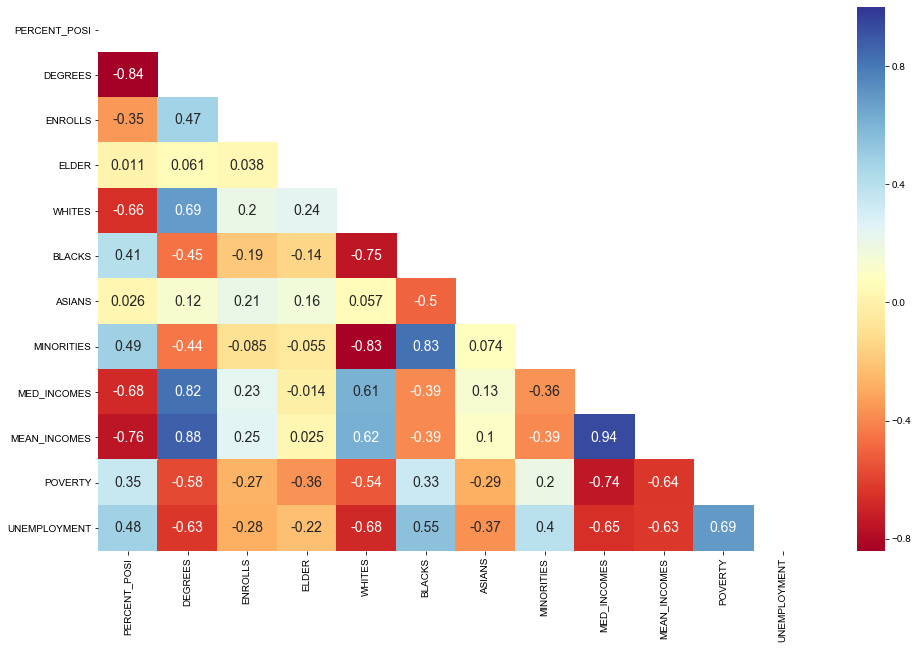

In [11]:
plt.figure(figsize=(16,10))
sns.heatmap(df_analysis.corr(), mask=mask, annot=True, annot_kws={"size": 14}, cmap="RdYlBu")
sns.set_style('white')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

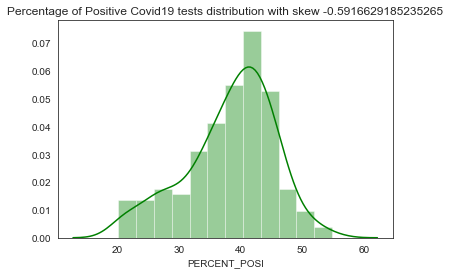

In [12]:
sns.distplot(df_analysis['PERCENT_POSI'], color='green')
plt.title('Percentage of Positive Covid19 tests distribution with skew {}' .format(df_analysis['PERCENT_POSI'].skew()))
plt.show()

# Training & Test Dataset Split

In [13]:
features = df_analysis.drop('PERCENT_POSI', axis =1)
tests = df_analysis[['PERCENT_POSI']]

X_train, X_test, y_train, y_test = train_test_split(features, tests, 
                                                    test_size=0.2, random_state=10)

# Multivariable Regression

In [14]:
regr = LinearRegression()
regr.fit(X_train, y_train)

print('Training data r-squared:', regr.score(X_train, y_train))
print('Test data r-squared:', regr.score(X_test, y_test))

print('Intercept', regr.intercept_[0])
print('Coef', regr.coef_)
pd.DataFrame(data=np.transpose(regr.coef_), index=X_train.columns, columns=['coef'])

Training data r-squared: 0.794922999995676
Test data r-squared: 0.6065749470002364
Intercept 60.26381860474568
Coef [[-2.26997285e-01 -9.68557549e-03  7.20441613e-02 -1.09723508e-01
  -2.36004238e-02 -4.10294696e-03 -2.77033707e-02  1.34828752e-05
  -3.38384434e-05 -2.01294909e-01 -1.32097902e-01]]


,coef
DEGREES,-0.226997
ENROLLS,-0.009686
ELDER,0.072044
WHITES,-0.109724
BLACKS,-0.023600
ASIANS,-0.004103
MINORITIES,-0.027703
MED_INCOMES,0.000013
MEAN_INCOMES,-0.000034
POVERTY,-0.201295


# p-value Evaluation

In [15]:
X_incl_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_incl_const)
results = model.fit()

pd.DataFrame({'coef': results.params, 'p-value': round(results.pvalues, 3)})


C:\Users\sonle\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,coef,p-value
const,60.263819,0.000
DEGREES,-0.226997,0.000
ENROLLS,-0.009686,0.779
ELDER,0.072044,0.321
WHITES,-0.109724,0.001
BLACKS,-0.023600,0.064
ASIANS,-0.004103,0.828
MINORITIES,-0.027703,0.191
MED_INCOMES,0.000013,0.691
MEAN_INCOMES,-0.000034,0.087


# Testing for Multicollinearity

In [16]:
vif = [] # empty list
for i in range(X_incl_const.shape[1]):
    vif.append(variance_inflation_factor(exog=X_incl_const.values, exog_idx=i))
    
pd.DataFrame({'coef_name': X_incl_const.columns, 
             'vif': np.around(vif, 2)})

C:\Users\sonle\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,coef_name,vif
0,const,224.57
1,DEGREES,7.92
2,ENROLLS,1.81
3,ELDER,1.98
4,WHITES,8.74
5,BLACKS,inf
6,ASIANS,inf
7,MINORITIES,inf
8,MED_INCOMES,19.03
9,MEAN_INCOMES,14.85


## Observations 
1. p-value is high for all features except for DEGREES, WHITES, and POVERTY. Still, because these features contain estimates, they are assumed to have high margins of error
2. VIF for all coefficients are < 10  except for BLACKS, ASIANS, MINORITIES (Group 1) and MED_INCOMES and MEAN_INCOMES (Group 2). This suggests multicollinearity exists within these two groups, especially in Group 1. 

# Baysian Information Criterion and Model Adjustments

In [17]:
# Original model with sqrt prices and all features
X_incl_const = sm.add_constant(X_train)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

org_coef = pd.DataFrame({'original': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('r-squared is', results.rsquared)

BIC is 797.1748781994241
r-squared is 0.7949229999956758


In [18]:
# Reduced model #1 excluding MED_INCOMES 
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['MED_INCOMES'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

reduced_coef1 = pd.DataFrame({'Reduced #1': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('r-squared is', results.rsquared)

BIC is 792.3981873147236
r-squared is 0.7946725820121097


In [19]:
# Reduced model #2 excluding MEAN_INCOMES 
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['MEAN_INCOMES'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

reduced_coef2 = pd.DataFrame({'Reduced #2': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('r-squared is', results.rsquared)

BIC is 795.4180119923765
r-squared is 0.790227614936234


In [20]:
# Modified model #1: excluding MEAN_INCOMES, BLACKS, and ASIANS
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['MEAN_INCOMES','BLACKS','ASIANS'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

modified1_coef = pd.DataFrame({'Modified #1': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('r-squared is', results.rsquared)

BIC is 791.3459212644867
r-squared is 0.7889192896093719


In [21]:
# Modified model #2: excluding MED_INCOMES, BLACKS, and ASIANS
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['MED_INCOMES','BLACKS','ASIANS'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

modified2_coef = pd.DataFrame({'Modified #2': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('r-squared is', results.rsquared)

BIC is 788.1690556364705
r-squared is 0.7936219642231132


In [22]:
# Modified model #3: excluding MEAN_INCOMES and MINORITIES
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['MEAN_INCOMES','MINORITIES'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

modified3_coef = pd.DataFrame({'Modified #3': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('r-squared is', results.rsquared)

BIC is 795.4180119923764
r-squared is 0.790227614936234


In [23]:
frames = [org_coef, reduced_coef1, reduced_coef2,modified1_coef, modified2_coef, modified3_coef]
pd.concat(frames, axis=1)

C:\Users\sonle\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,original,Reduced #1,Reduced #2,Modified #1,Modified #2,Modified #3
ASIANS,0.828,0.839,0.955,NaN,NaN,0.509
BLACKS,0.064,0.063,0.071,NaN,NaN,0.109
DEGREES,0.000,0.000,0.000,0.000,0.000,0.000
ELDER,0.321,0.351,0.626,0.589,0.320,0.626
ENROLLS,0.779,0.698,0.898,0.990,0.769,0.898
MEAN_INCOMES,0.087,0.029,NaN,NaN,0.025,NaN
MED_INCOMES,0.691,NaN,0.160,0.152,NaN,0.160
MINORITIES,0.191,0.194,0.255,0.109,0.081,NaN
POVERTY,0.004,0.000,0.000,0.000,0.000,0.000
UNEMPLOYMENT,0.459,0.466,0.575,0.327,0.258,0.575


### "Modified model 2" seems to have the best combination of p-values

In [22]:
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['MED_INCOMES','BLACKS','ASIANS'], axis=1)

vif = [] # empty list
for i in range(X_incl_const.shape[1]):
    vif.append(variance_inflation_factor(exog=X_incl_const.values, exog_idx=i))
    
pd.DataFrame({'coef_name': X_incl_const.columns, 
             'vif': np.around(vif, 2)})


,coef_name,vif
0,const,152.33
1,DEGREES,7.74
2,ENROLLS,1.68
3,ELDER,1.35
4,WHITES,8.60
5,MINORITIES,4.71
6,MEAN_INCOMES,6.16
7,POVERTY,2.85
8,UNEMPLOYMENT,2.56


In [23]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Positive Tests')
    plt.ylabel('Features')

    plt.show()
    plt.close()

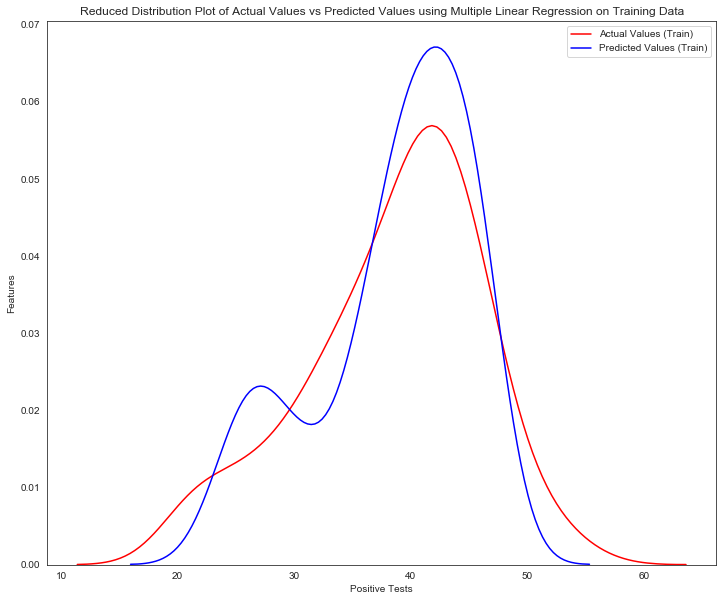

In [24]:
tests = df_analysis['PERCENT_POSI']
features = df_analysis.drop(['PERCENT_POSI','MED_INCOMES', 'BLACKS', 'ASIANS'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, tests, 
                                                    test_size=0.2, random_state=10)

model = LinearRegression()
model.fit(X_train, y_train)

yhat_train = model.predict(X_train)

Title = 'Reduced Distribution Plot of Actual Values vs Predicted Values using Multiple Linear Regression on Training Data'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)


reduced_corr_train = np.around(np.corrcoef(y_train.to_list(),yhat_train.tolist())[0,1], 2)
reduced_train_rsquared = round(r2_score(y_train,yhat_train),2)
reduced_train_mse = round(mse(y_train,yhat_train),3)

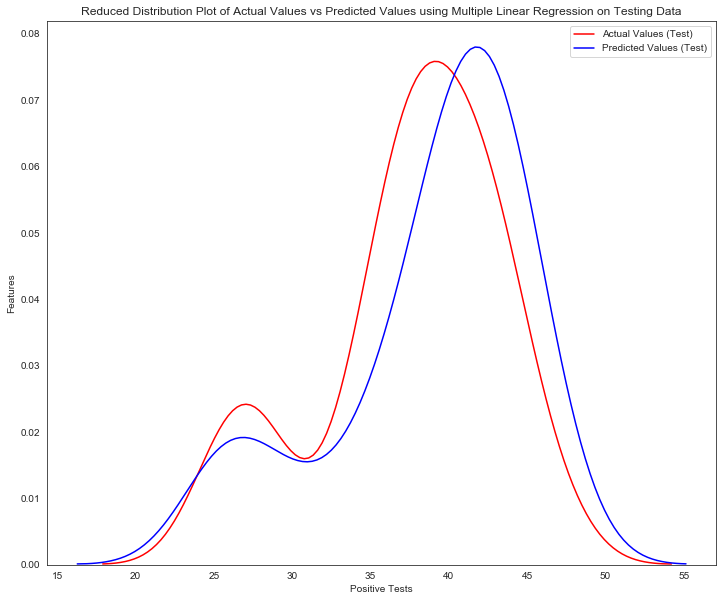

In [25]:
yhat_test = model.predict(X_test)

Title = 'Reduced Distribution Plot of Actual Values vs Predicted Values using Multiple Linear Regression on Testing Data'
DistributionPlot(y_test, yhat_test, "Actual Values (Test)", "Predicted Values (Test)", Title)

reduced_corr_test = np.around(np.corrcoef(y_test.to_list(),yhat_test.tolist())[0,1], 2)
reduced_test_rsquared = round(r2_score(y_test,yhat_test),2)
reduced_test_mse = round(mse(y_test,yhat_test),3)

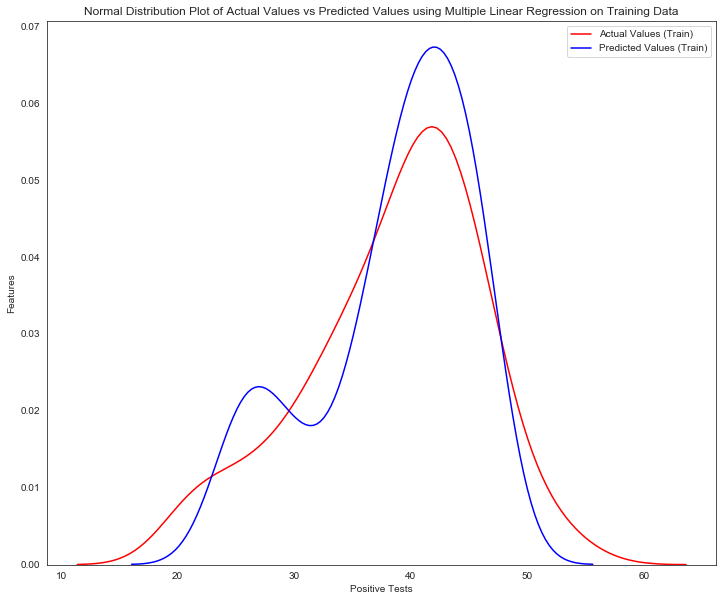

In [26]:
tests = df_analysis['PERCENT_POSI']
features = df_analysis.drop(['PERCENT_POSI'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, tests, 
                                                    test_size=0.2, random_state=10)


model = LinearRegression()
model.fit(X_train, y_train)

yhat_train = model.predict(X_train)

Title = 'Normal Distribution Plot of Actual Values vs Predicted Values using Multiple Linear Regression on Training Data'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

normal_corr_train = np.around(np.corrcoef(y_train.to_list(),yhat_train.tolist())[0,1], 2)
normal_train_rsquared = round(r2_score(y_train,yhat_train),2)
normal_train_mse = round(mse(y_train,yhat_train),3)

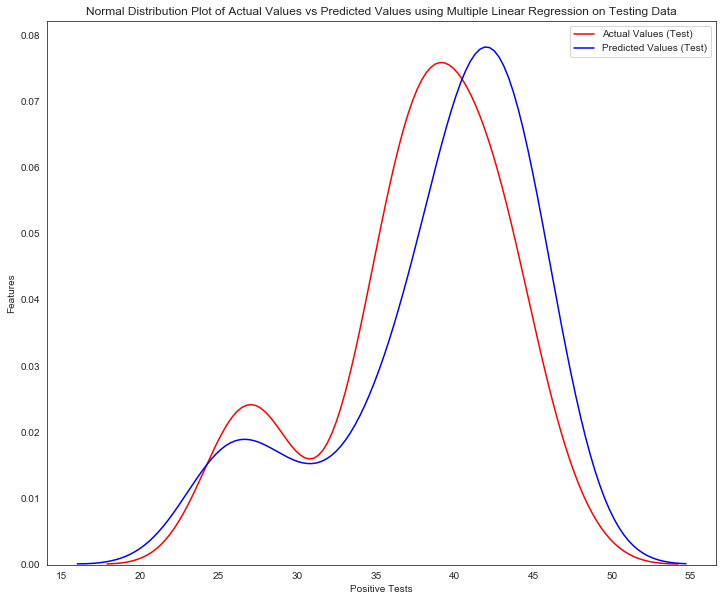

In [27]:
yhat_test = model.predict(X_test)

Title = 'Normal Distribution Plot of Actual Values vs Predicted Values using Multiple Linear Regression on Testing Data'
DistributionPlot(y_test, yhat_test, "Actual Values (Test)", "Predicted Values (Test)", Title)

normal_corr_test = np.around(np.corrcoef(y_test.to_list(),yhat_test.tolist())[0,1], 2)
normal_test_rsquared = round(r2_score(y_test,yhat_test),2)
normal_test_mse = round(mse(y_test,yhat_test),3)

In [28]:
MLR_df = pd.DataFrame({'Corr Train': [reduced_corr_train, normal_corr_train],
              'Corr Test': [reduced_corr_test, normal_corr_test],
              'R-Squared Train': [reduced_train_rsquared, normal_train_rsquared],
              'R-Squared Test': [reduced_test_rsquared, normal_test_rsquared],
              'MSE Train': [reduced_train_mse, normal_train_mse],
             'MSE Test': [reduced_test_mse, normal_test_mse]}, 
            index=['Reduced Model', 'Full Normal Tests Model'])

MLR_df

,Corr Train,Corr Test,R-Squared Train,R-Squared Test,MSE Train,MSE Test
Reduced Model,0.89,0.84,0.79,0.61,11.428,12.619
Full Normal Tests Model,0.89,0.85,0.79,0.61,11.356,12.714


## Observations
1. The Reduced Model has approximately the same Correlation coefficients, R-Squared, and MSE as the Original model for both train and test data 
2. The former, however, benefits from having features with much more improved p-values and less multicollinearity 

## Try Polynomial Regression to find a better model

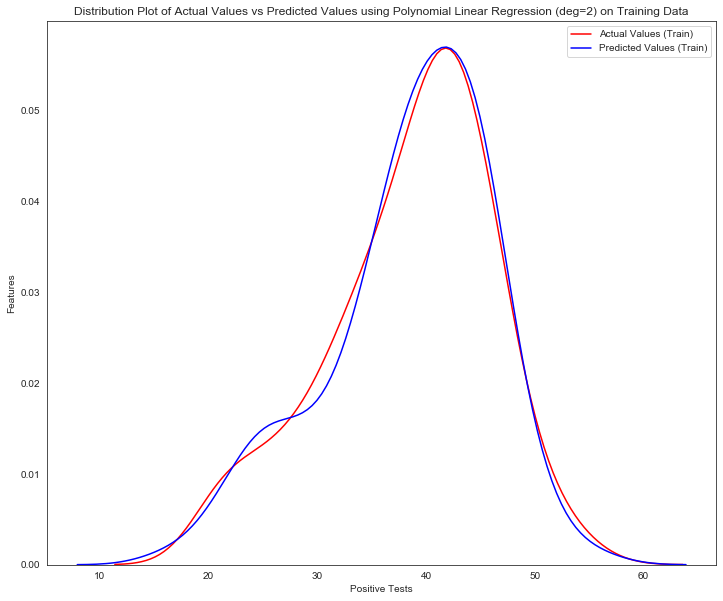

In [29]:
tests = df_analysis['PERCENT_POSI']
features = df_analysis.drop(['PERCENT_POSI','MED_INCOMES', 'BLACKS', 'ASIANS'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, tests, 
                                                    test_size=0.2, random_state=10)


polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)

model = LinearRegression()
model.fit(x_poly, y_train)

yhat_train = model.predict(x_poly)

Title = 'Distribution Plot of Actual Values vs Predicted Values using Polynomial Linear Regression (deg=2) on Training Data'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

poly2_corr_train = np.around(np.corrcoef(y_train.to_list(),yhat_train.tolist())[0,1], 2)
poly2_train_rsquared = round(r2_score(y_train,yhat_train),2)
poly2_train_mse = round(mse(y_train,yhat_train),3)


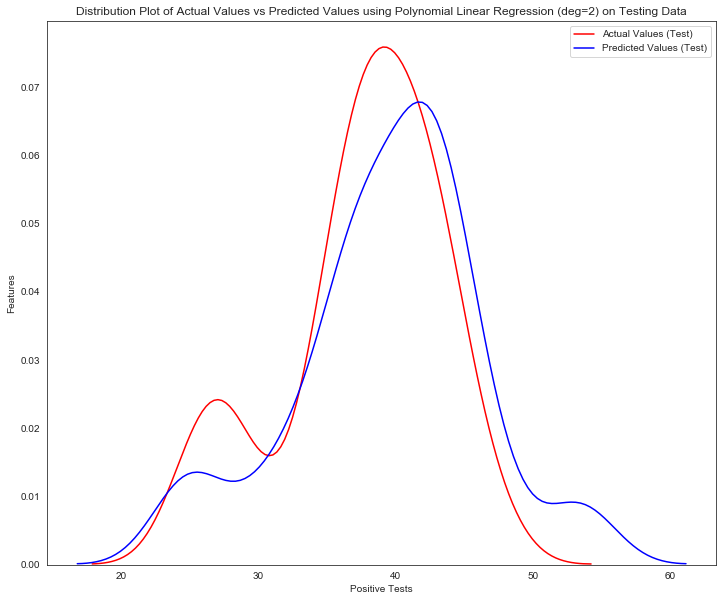

In [30]:
x_poly = polynomial_features.fit_transform(X_test)

yhat_test = model.predict(x_poly)

Title = 'Distribution Plot of Actual Values vs Predicted Values using Polynomial Linear Regression (deg=2) on Testing Data'
DistributionPlot(y_test, yhat_test, "Actual Values (Test)", "Predicted Values (Test)", Title)

poly2_corr_test = np.around(np.corrcoef(y_test.to_list(),yhat_test.tolist())[0,1], 2)
poly2_test_rsquared = round(r2_score(y_test,yhat_test),2)
poly2_test_mse = round(mse(y_test,yhat_test),3)

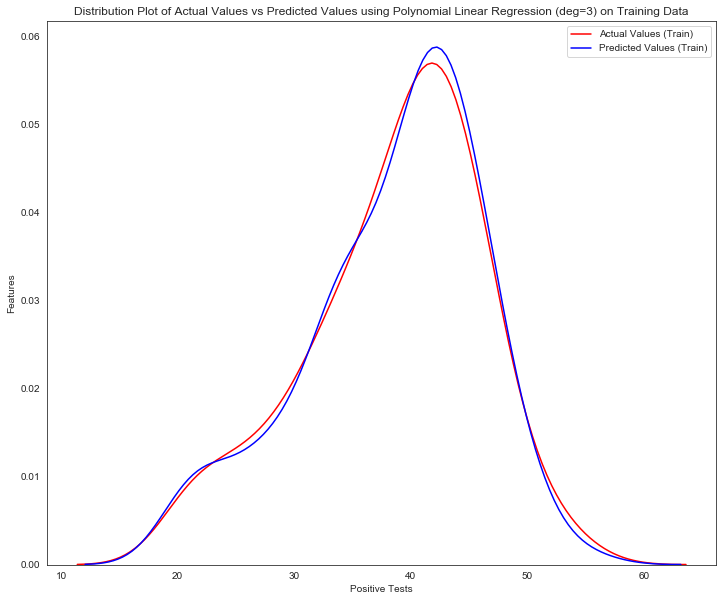

In [31]:
tests = df_analysis['PERCENT_POSI']
features = df_analysis.drop(['PERCENT_POSI','MED_INCOMES', 'BLACKS', 'ASIANS'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, tests, 
                                                    test_size=0.2, random_state=10)


polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X_train)

model = LinearRegression()
model.fit(x_poly, y_train)

yhat_train = model.predict(x_poly)

Title = 'Distribution Plot of Actual Values vs Predicted Values using Polynomial Linear Regression (deg=3) on Training Data'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

poly3_corr_train = np.around(np.corrcoef(y_train.to_list(),yhat_train.tolist())[0,1], 2)
poly3_train_rsquared = round(r2_score(y_train,yhat_train),2)
poly3_train_mse = round(mse(y_train,yhat_train),3)


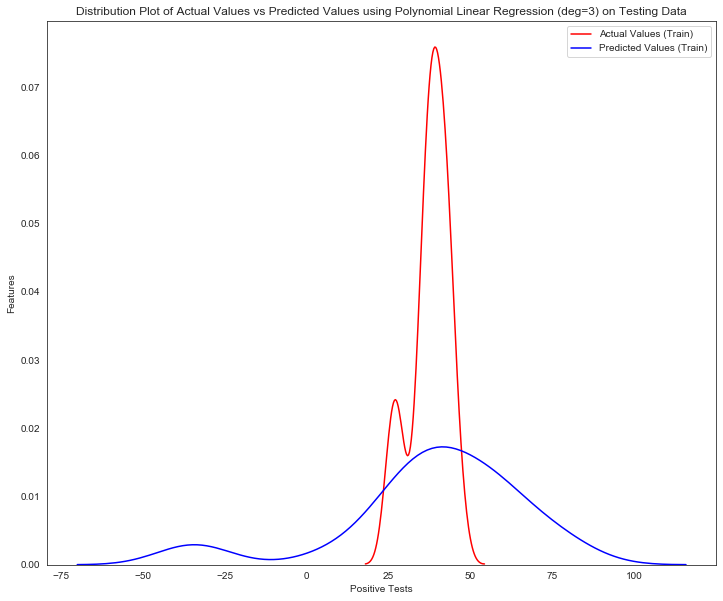

In [32]:
x_poly = polynomial_features.fit_transform(X_test)

yhat_test = model.predict(x_poly)

Title = 'Distribution Plot of Actual Values vs Predicted Values using Polynomial Linear Regression (deg=3) on Testing Data'
DistributionPlot(y_test, yhat_test, "Actual Values (Train)", "Predicted Values (Train)", Title)

poly3_corr_test = np.around(np.corrcoef(y_test.to_list(),yhat_test.tolist())[0,1], 2)
poly3_test_rsquared = round(r2_score(y_test,yhat_test),2)
poly3_test_mse = round(mse(y_test,yhat_test),3)

In [33]:
train_metrics = pd.DataFrame({'Corr Train': [reduced_corr_train, normal_corr_train, poly2_corr_train, poly3_corr_train],
              'Corr Test': [reduced_corr_test, normal_corr_test, poly2_corr_test, poly3_corr_test],
              'R-Squared Train': [reduced_train_rsquared, normal_train_rsquared, poly2_train_rsquared,poly3_train_rsquared],
              'R-Squared Test': [reduced_test_rsquared, normal_test_rsquared, poly2_test_rsquared,poly3_test_rsquared],
              'MSE Train': [reduced_train_mse, normal_train_mse, poly2_train_mse,poly3_train_mse],
             'MSE Test': [reduced_test_mse, normal_test_mse,poly2_test_mse,poly3_test_mse]}, 
            index=['Reduced Model', 'Full Normal Tests Model','Reduced Poly = 2 Model', 'Reduced Poly =3 Model'])

train_metrics



,Corr Train,Corr Test,R-Squared Train,R-Squared Test,MSE Train,MSE Test
Reduced Model,0.89,0.84,0.79,0.61,11.428,12.619
Full Normal Tests Model,0.89,0.85,0.79,0.61,11.356,12.714
Reduced Poly = 2 Model,0.88,0.47,0.76,-0.36,13.529,44.016
Reduced Poly =3 Model,0.99,0.30,0.98,-20.88,1.084,706.975


### Using polynomial functions seems to cause overfitting. Try Ridge to improve the Poly = 2 model

In [42]:


tests = df_analysis['PERCENT_POSI']
features = df_analysis.drop(['PERCENT_POSI','MED_INCOMES', 'BLACKS', 'ASIANS'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, tests, 
                                                    test_size=0.2, random_state=10)


polynomial_features= PolynomialFeatures(degree=2)
x_train_pr=polynomial_features.fit_transform(X_train)
x_test_pr=polynomial_features.fit_transform(X_test)

In [43]:
Rsqu_test = []
Rsqu_train = []
dummy1 = []
ALFA = np.array(range(0,10))
for alfa in ALFA:
    RigeModel = Ridge(alpha=alfa) 
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))
    
    

C:\Users\sonle\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.94599e-23): result may not be accurate.
  overwrite_a=True).T
C:\Users\sonle\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.89198e-23): result may not be accurate.
  overwrite_a=True).T
C:\Users\sonle\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.83797e-23): result may not be accurate.
  overwrite_a=True).T
C:\Users\sonle\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.78396e-23): result may not be accurate.
  overwrite_a=True).T
C:\Users\sonle\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.72995e-23): result may not be accurate.
  overwrite_a=True).T
C:\Users\sonle\Anaconda3\lib\site-packages\sklearn\linear_mo

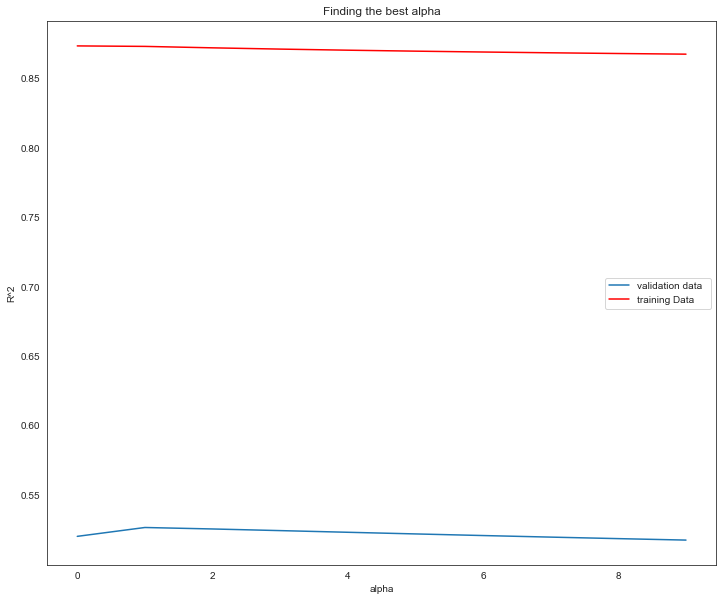

In [44]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(ALFA,Rsqu_test, label='validation data  ')
plt.plot(ALFA,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.title('Finding the best alpha')
plt.legend()

In [37]:
best_alfa = ALFA[Rsqu_test.index(max(Rsqu_test))]

C:\Users\sonle\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.94599e-23): result may not be accurate.
  overwrite_a=True).T


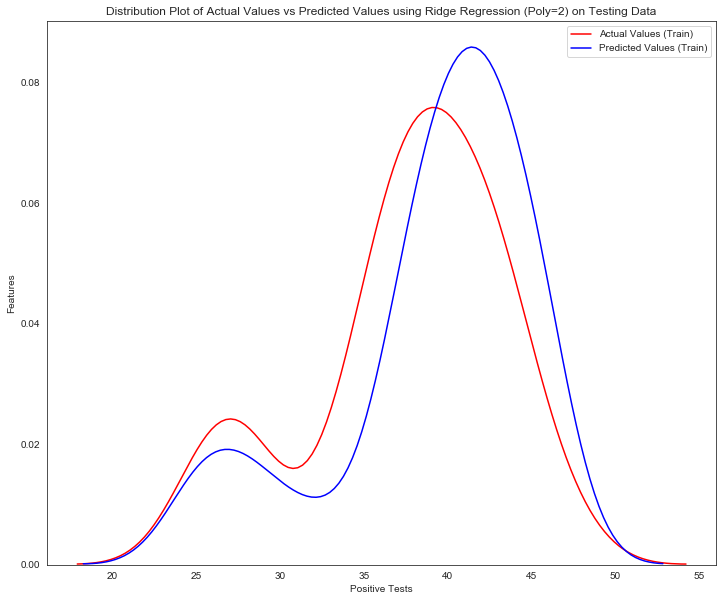

In [38]:
RigeModel=Ridge(alpha=best_alfa)
RigeModel.fit(x_train_pr, y_train)
yhat = RigeModel.predict(x_test_pr)

Title = 'Distribution Plot of Actual Values vs Predicted Values using Ridge Regression (Poly=2) on Testing Data'
DistributionPlot(y_test, yhat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [39]:
ridge_corr_test = np.around(np.corrcoef(y_test.to_list(),yhat.tolist())[0,1], 2)
ridge_test_rsquared = round(r2_score(y_test,yhat),2)
ridge_test_mse = round(mse(y_test,yhat),3)

print('Correlation coefficient from ridge regression is: {}' .format(ridge_corr_test))
print('R-Squared for ridge regression is: {}' .format(ridge_test_rsquared))
print('MSE for ridge regression is: {} '.format(round(ridge_test_mse)))

Correlation coefficient from ridge regression is: 0.81
R-Squared for ridge regression is: 0.53
MSE for ridge regression is: 15.0 


In [48]:
tests = df_analysis['PERCENT_POSI']
features = df_analysis.drop(['PERCENT_POSI','MED_INCOMES', 'BLACKS', 'ASIANS'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, tests, 
                                                    test_size=0.2, random_state=10)

model = LinearRegression()
model.fit(X_train, y_train)
pd.DataFrame({'coef': model.coef_}, index=features.columns)

,coef
DEGREES,-0.225150
ENROLLS,-0.009731
ELDER,0.059355
WHITES,-0.112810
MINORITIES,-0.051063
MEAN_INCOMES,-0.000029
POVERTY,-0.221666
UNEMPLOYMENT,-0.185683
